In [1]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for building and training neural networks
import tensorflow as tf

# custom functions
import utils

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
# Load the dataset from a text file
data = np.loadtxt(r"C:\Users\sarth\OneDrive\Documents\Machine Learning\Tensor Flow and Neural Network\Week 3\data_w3_ex2.csv", delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


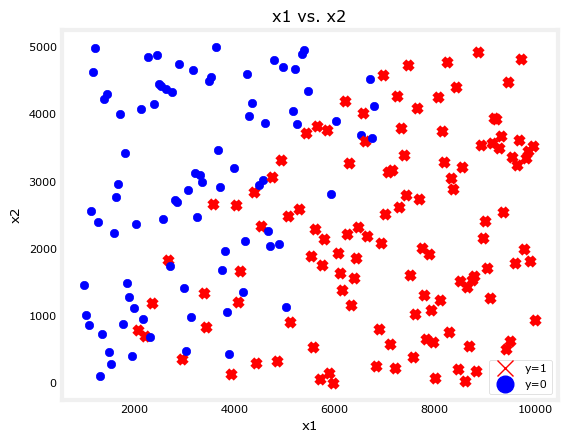

In [5]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

In [6]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [7]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

In [8]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


In [9]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = utils.build_models()

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

2/2 [==============================] - 0s 0s/step
Training model_2...
Done!

2/2 [==============================] - 0s 0s/step
Training model_3...
Done!

2/2 [==============================] - 0s 0s/step
Model 1: Training Set Classification Error: 0.05833, CV Set Classification Error: 0.12500
Model 2: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.15000
Model 3: Training Set Classification Error: 0.08333, CV Set Classification Error: 0.17500


In [10]:
# Select the model with the lowest error
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 [==============================] - 0s 0s/step
Selected Model: 3
Training Set Classification Error: 0.0833
CV Set Classification Error: 0.1750
Test Set Classification Error: 0.2000
